# LANL EARTHQUAKE PROJECT

## packages and parameters

In [2]:
import numpy as np 
import pandas as pd
import os
%matplotlib inline

import zipfile
import pickle
import random
from scipy import stats
from scipy import fftpack

from xgboost import XGBRegressor
import xgboost
import seaborn as sns
import matplotlib.pyplot as plt # may remove later

from sklearn.model_selection import train_test_split
from pathlib import Path

import heapq

#### set project parameters

In [3]:
# edit
PROJECT_DIR = Path('/notebooks/storage/earthquake')

#### change `pwd` to `PROJECT_DIR`

In [4]:
os.chdir(PROJECT_DIR)

print(os.getcwd())
print(os.listdir())

/storage/earthquake
['test_samples.pickle', 'train.csv', 'leaked_samples_eng.pickle', 'consecutive_samples.pickle', 'submission.csv', 'model_xgb.pickle', 'refactor.ipynb', 'test_samples_eng.pickle', 'leaked_samples.pickle', 'model_4096_all.pickle', 'train.pickle', '.ipynb_checkpoints', 'test']


## download/unzip/load data from kaggle
- run once -> comment out
- ADD: NOTE ON WHAT HAPPENS IF IT IS RUN TWICE, REPLACEMENT OR COLLISION ????

In [ ]:
# %%time
# !kaggle competitions download LANL-Earthquake-Prediction

#### unzip kaggle files
NOTE: run once -> comment out

In [ ]:
# %%time

# train_zip='train.csv.zip'
# test_zip='test.zip'
# earthquake_dir='.'
# test_dir='./test'

# zip_ref=zipfile.ZipFile(train_zip,'r')
# zip_ref.extractall(earthquake_dir)
# zip_ref.close()

# zip_ref=zipfile.ZipFile(test_zip,'r')
# zip_ref.extractall(test_dir)
# zip_ref.close()

#### read train csv -> convert to dataframe -> pickle
NOTE: run once -> pickle `train` -> comment out

In [ ]:
# %%time 

# train = pd.read_csv('./train.csv', dtype={"acoustic_data": np.int16, "time_to_failure": np.float32})

#### pickle `train` dataframe
- NOTE: run once then comment out
- CAUTION !!! code below overwrites `train`!!!

In [ ]:
# %%time

# with open('/notebooks/storage/earthquake/train.pickle','wb') as f:
#     pickle.dump(train,f,pickle.HIGHEST_PROTOCOL)

#### delete `train` dataframe from ram

In [5]:
del train

#### load `train` dataframe

In [4]:
%%time

with open(PROJECT_DIR/'train.pickle','rb') as f:
    train = pickle.load(f)

train.tail()

CPU times: user 1.22 s, sys: 5.27 s, total: 6.5 s
Wall time: 1min 4s


## generate consecutive samples

#### set `consecutive_sample` parameters

In [ ]:
# edit
CONS_FILENAME = 'consecutive_samples'

#leave as-is
cons_filename = PROJECT_DIR/str(CONS_FILENAME+'.pickle')

In [ ]:
def generateConsecutive(train):
    '''
    input: train dataframe (dim: #entries x 2 features: acoustic_data/time_to_failure)
    returns: dataframe with length/sample_length consecutive samples, each with:
        sequence = np.array(150k,) and time_to_failure = float
    '''
    
    samples = []
    
    length = len(train)
    sample_length = 150000
    max_index = length-1
    max_start = max_index - sample_length
    
    for i in range(length//sample_length):
        
        start = i*sample_length
        end = (i+1)*sample_length
        
        samples += [[train['acoustic_data'].values[start:end],train['time_to_failure'].values[end]]]
                
    df = pd.DataFrame(samples)
        
    df = df.rename(columns = {0:'sequence',1:'time_to_failure'})
    
    return df

In [ ]:
%%time

consecutive_samples = generateConsecutive(train)

In [ ]:
consecutive_samples.tail()

 #### pickle `consecutive_samples`

NOTE: run once -> comment out

In [ ]:
# %%time

# with open(cons_filename,'wb') as f:
#     pickle.dump(consecutive_samples,f,pickle.HIGHEST_PROTOCOL)

#### delete `consecutive_samples` from ram

In [ ]:
del consecutive_samples

#### load pickled `consecutive_samples` from PROJECT_DIR

In [ ]:
%%time

with open(cons_filename,'rb') as f:
    consecutive_samples = pickle.load(f)

In [ ]:
consecutive_samples.tail()

## generate N random samples
with replacement

In [ ]:
# edit
RAND_FILENAME = 'random_samples'

#leave unchanged
rand_filename = PROJECT_DIR/str(RAND_FILENAME+'.pickle')

In [ ]:
def generateRandom(train,n):
    '''
    input: train dataframe (dim: #entries x 2 features: acoustic_data/time_to_failure)
    returns: dataframe with n random samples, each with:
        sequence = np.array(150k,) and time_to_failure = float
    '''
    
    samples = []
    
    length = len(train)
    sample_length = 150000
    max_index = length-1
    max_start = max_index - sample_length
    
    for i in range(n):
        
        start = random.randint(0,max_start)
        end = start + sample_length
        
        samples += [[np.array(train['acoustic_data'].values[start:end]),train['time_to_failure'].values[end]]]
                
    df = pd.DataFrame(samples)
        
    df = df.rename(columns = {0:'sequence',1:'time_to_failure'})
    
    return df

In [ ]:
%%time

random_samples = generateRandom(train,1000)

In [ ]:
random_samples.tail()

 #### pickle `random_samples`

NOTE: run once -> comment out

In [ ]:
%%time

with open(rand_filename,'wb') as f:
    pickle.dump(random_samples,f,pickle.HIGHEST_PROTOCOL)

#### delete `random_samples` from ram

In [ ]:
del random_samples

#### load pickled `consecutive_samples` from `PROJECT_DIR`

In [ ]:
%%time

with open(rand_filename,'rb') as f:
    random_samples = pickle.load(f)

In [ ]:
random_samples.tail()

## Generate leaked samples

In [6]:
# edit
LEAKED_FILENAME = 'leaked_samples'
N_LEAKED_SAMPLES = 10

#leave unchanged
leaked_filename = PROJECT_DIR/str(LEAKED_FILENAME+'.pickle')

In [ ]:
# earthquake times
eq0 = (0,5656574)
eq3 = (104677355,138772454)
eq5 = (187641819,218652631)
eq6 = (218652629,245829586)
eq8 = (307838916,338276288)
eq12 = (461811622,495800226)
eq13 = (495800224,528777116)
eq16 = (621985672,629145480)

nogo = [eq0,eq16]
nogo1 = nogo + [eq3,eq5,eq6]
nogo2 = nogo + [eq3,eq8,eq12,eq13]
nogo3 = nogo + [eq6,eq8,eq13]
nogo4 = nogo + [eq6,eq8,eq12]

In [ ]:
def is_valid(start,end,nogo_list):
    
    valid = True
    
    for a,b in nogo_list:
        
        if start>a and start<b:
            valid = False
        if end>a and end<b:
            valid = False
        
    return valid
        
    

In [ ]:
def generateLeaked(train,n,nogo_list):
    
    samples = []
    
    length = len(train)
    sample_length = 150000
    max_index = length-1
    max_start = max_index - sample_length
    
    for i in range(n):
        
        start = random.randint(0,max_start)
        end = start + sample_length
        
        while not is_valid(start,end,nogo_list):
            start = random.randint(0,max_start)
            end = start + sample_length
        
        samples += [[np.array(train['acoustic_data'].values[start:end]),train['time_to_failure'].values[end]]]
                
    df = pd.DataFrame(samples)
        
    df = df.rename(columns = {0:'sequence',1:'time_to_failure'})
    
    return df

In [ ]:
%%time

leaked_samples_list = []

nogos = [nogo1,nogo2,nogo3,nogo4]

for nogo in nogos:

    current_sample = generateLeaked(train,N_LEAKED_SAMPLES,nogo)
    
    leaked_samples_list += [current_sample]

In [ ]:
leaked_samples_list[3].tail()

In [ ]:
leaked_samples = pd.concat(leaked_samples_list, axis=0)
leaked_samples = leaked_samples.reset_index()
leaked_samples = leaked_samples.drop(labels=['index'],axis=1)

In [ ]:
leaked_samples.tail()

In [ ]:
leaked_samples.describe()

 #### pickle `leaked_samples`

NOTE: run once -> comment out

In [ ]:
# %%time

# with open(leaked_filename,'wb') as f:
#     pickle.dump(leaked_samples,f,pickle.HIGHEST_PROTOCOL)

#### delete `leaked_samples` from ram

In [ ]:
del leaked_samples

#### load pickled `leaked_samples` from `PROJECT_DIR`

In [7]:
%%time

with open(leaked_filename,'rb') as f:
    leaked_samples = pickle.load(f)

CPU times: user 482 ms, sys: 1.12 s, total: 1.6 s
Wall time: 22.8 s


In [8]:
leaked_samples.tail()

,index,sequence,time_to_failure
4091,1019,"[10, 9, 6, 1, 4, 5, 4, 2, 1, 1, 8, 12, 8, 10, ...",9.925695
4092,1020,"[-1, 3, 6, 7, 8, 5, 6, 3, 2, 2, 0, 1, 2, 2, 2,...",7.248997
4093,1021,"[9, 4, 7, 6, 5, 12, 11, 6, 0, 0, 1, 0, -1, -2,...",0.758697
4094,1022,"[5, 8, 8, 6, 3, 4, 4, 6, 5, 5, 12, 11, 2, -1, ...",11.012397
4095,1023,"[-1, 2, 5, 3, 3, 6, 8, 5, 5, 2, 7, 8, 4, 2, 3,...",3.163897


## full sequence features
add features to a given sample

In [ ]:
def generateFullFeatures(samples_df):
    
    #defining x as matrix of sequence data
    x = []
    for index,row in samples_df.iterrows():
        x += [samples_df.loc[index,'sequence']]    
    x = np.stack(x)
    x_abs = np.absolute(x)
    
    length=150000
    
    #non-abs
    samples_df['mean'] = np.mean(x,axis=1)
    samples_df['median'] = np.median(x,axis=1)
    samples_df['std'] = np.std(x,axis=1)
    
    samples_df['kurtosis'] = stats.kurtosis(x,axis=1)   
    samples_df['m2'] = stats.moment(x,axis=1,moment=2)
    samples_df['m3'] = stats.moment(x,axis=1,moment=3)
    samples_df['skew'] = stats.skew(x,axis=1)
    samples_df['variation'] = stats.variation(x,axis=1)
    samples_df['sem'] = stats.sem(x,axis=1)

    samples_df['iqr25_75'] = stats.iqr(x,axis=1,rng=(25,75))
    samples_df['iqr10_90'] = stats.iqr(x,axis=1,rng=(10,90))
    samples_df['iqr5_95'] = stats.iqr(x,axis=1,rng=(5,95))
    samples_df['iqr1_99'] = stats.iqr(x,axis=1,rng=(1,99))
    
    
    #abs
    samples_df['mean_abs'] = np.mean(x_abs,axis=1)
    samples_df['median_abs'] = np.median(x_abs,axis=1)
    samples_df['std_abs'] = np.std(x_abs,axis=1)
    
    samples_df['kurtosis_abs'] = stats.kurtosis(x_abs,axis=1)   
    samples_df['m2_abs'] = stats.moment(x_abs,axis=1,moment=2)
    samples_df['m3_abs'] = stats.moment(x_abs,axis=1,moment=3)
    samples_df['skew_abs'] = stats.skew(x_abs,axis=1)
    samples_df['variation_abs'] = stats.variation(x_abs,axis=1)
    samples_df['sem_abs'] = stats.sem(x_abs,axis=1)

    
    samples_df['iqr25_75_abs'] = stats.iqr(x_abs,axis=1,rng=(25,75))
    samples_df['iqr10_90_abs'] = stats.iqr(x_abs,axis=1,rng=(10,90))
    samples_df['iqr5_95_abs'] = stats.iqr(x_abs,axis=1,rng=(5,95))
    samples_df['iqr1_99_abs'] = stats.iqr(x_abs,axis=1,rng=(1,99))
    
    
    #slices
    slices_list = [2,4]
    
    for slices in slices_list:

        for i in range(slices):

            suffix = '_'+str(slices)+'_'+str(i+1)

            #create same as above, but for first half and second half
            
            x_slice = x[:,i*(length//slices):(i+1)*(length//slices)]
            x_abs_slice = np.absolute(x_slice)

            #non-abs
            samples_df['mean'+suffix] = np.mean(x_slice,axis=1)
            samples_df['median'+suffix] = np.median(x_slice,axis=1)
            samples_df['std'+suffix] = np.std(x_slice,axis=1)

            samples_df['kurtosis'+suffix] = stats.kurtosis(x_slice,axis=1)
            samples_df['m2'+suffix] = stats.moment(x_slice,axis=1,moment=2)
            samples_df['m3'+suffix] = stats.moment(x_slice,axis=1,moment=3)
            samples_df['skew'+suffix] = stats.skew(x_slice,axis=1)
            samples_df['variation'+suffix] = stats.variation(x_slice,axis=1)
            samples_df['sem'+suffix] = stats.sem(x_slice,axis=1)

            samples_df['iqr25_75'+suffix] = stats.iqr(x_slice,axis=1,rng=(25,75))
            samples_df['iqr10_90'+suffix] = stats.iqr(x_slice,axis=1,rng=(10,90))
            samples_df['iqr5_95'+suffix] = stats.iqr(x_slice,axis=1,rng=(5,95))
            samples_df['iqr1_99'+suffix] = stats.iqr(x_slice,axis=1,rng=(1,99))


            #abs
            samples_df['mean_abs'+suffix] = np.mean(x_abs_slice,axis=1)
            samples_df['median_abs'+suffix] = np.median(x_abs_slice,axis=1)
            samples_df['std_abs'+suffix] = np.std(x_abs_slice,axis=1)

            samples_df['kurtosis_abs'+suffix] = stats.kurtosis(x_abs_slice,axis=1)
            samples_df['m2_abs'+suffix] = stats.moment(x_abs_slice,axis=1,moment=2)
            samples_df['m3_abs'+suffix] = stats.moment(x_abs_slice,axis=1,moment=3)
            samples_df['skew_abs'+suffix] = stats.skew(x_abs_slice,axis=1)
            samples_df['variation_abs'+suffix] = stats.variation(x_abs_slice,axis=1)
            samples_df['sem_abs'+suffix] = stats.sem(x_abs_slice,axis=1)


            samples_df['iqr25_75_abs'+suffix] = stats.iqr(x_abs_slice,axis=1,rng=(25,75))
            samples_df['iqr10_90_abs'+suffix] = stats.iqr(x_abs_slice,axis=1,rng=(10,90))
            samples_df['iqr5_95_abs'+suffix] = stats.iqr(x_abs_slice,axis=1,rng=(5,95))
            samples_df['iqr1_99_abs'+suffix] = stats.iqr(x_abs_slice,axis=1,rng=(1,99))            
            

In [ ]:
def FFTSingle(index,sequence,samples_df):
    
    x_realfft = np.real(fftpack.fft(sequence))
    
    band1 = x_realfft[600:900]
    band2 = x_realfft[1100:1450]
    band3 = x_realfft[1450:1900]
    band4 = x_realfft[1950:2800]
    band5 = x_realfft[33000:42000]
    
    samples_df.loc[index,'band1_alt'] = np.max(band1)
    samples_df.loc[index,'band1_freq'] = np.argmax(band1)
    samples_df.loc[index,'band2_alt'] = np.max(band2)
    samples_df.loc[index,'band2_freq'] = np.argmax(band2)
    samples_df.loc[index,'band3_alt'] = np.max(band3)
    samples_df.loc[index,'band3_freq'] = np.argmax(band3)
    samples_df.loc[index,'band4_alt'] = np.max(band4)
    samples_df.loc[index,'band4_freq'] = np.argmax(band4)
    samples_df.loc[index,'band5_alt'] = np.max(band5)
    samples_df.loc[index,'band5_freq'] = np.argmax(band5)
    
def generateFFTFeatures(samples_df):
    
    for index, row in samples_df.iterrows():
        
        FFTSingle(index,row['sequence'],samples_df)

## generate features for a sample

In [10]:
#edit
eng_samples = leaked_samples

In [5]:
#edit
eng_samples_name = 'leaked_samples'

#leave as-is
eng_samples_filename = PROJECT_DIR/str(eng_samples_name+'_eng.pickle')

In [ ]:
%%time

generateFullFeatures(eng_samples)
generateFFTFeatures(eng_samples)

In [12]:
eng_samples.tail()

,index,sequence,time_to_failure
4091,1019,"[10, 9, 6, 1, 4, 5, 4, 2, 1, 1, 8, 12, 8, 10, ...",9.925695
4092,1020,"[-1, 3, 6, 7, 8, 5, 6, 3, 2, 2, 0, 1, 2, 2, 2,...",7.248997
4093,1021,"[9, 4, 7, 6, 5, 12, 11, 6, 0, 0, 1, 0, -1, -2,...",0.758697
4094,1022,"[5, 8, 8, 6, 3, 4, 4, 6, 5, 5, 12, 11, 2, -1, ...",11.012397
4095,1023,"[-1, 2, 5, 3, 3, 6, 8, 5, 5, 2, 7, 8, 4, 2, 3,...",3.163897


 #### pickle `eng_samples`

NOTE: run once -> comment out

In [ ]:
# %%time

# with open(eng_samples_filename,'wb') as f:
#     pickle.dump(eng_samples,f,pickle.HIGHEST_PROTOCOL)

#### delete `eng_samples` from ram

In [ ]:
del eng_samples

#### load pickled `eng_samples` from PROJECT_DIR

In [6]:
%%time

with open(eng_samples_filename,'rb') as f:
    eng_samples = pickle.load(f)

CPU times: user 347 ms, sys: 1.05 s, total: 1.4 s
Wall time: 1.4 s


In [7]:
eng_samples.tail()

,index,sequence,time_to_failure,mean,median,std,kurtosis,m2,m3,skew,...,band1_alt,band1_freq,band2_alt,band2_freq,band3_alt,band3_freq,band4_alt,band4_freq,band5_alt,band5_freq
4091,1019,"[10, 9, 6, 1, 4, 5, 4, 2, 1, 1, 8, 12, 8, 10, ...",9.925695,4.739147,5.0,4.807922,22.788400,23.116116,4.833004,0.043486,...,1685.860805,284.0,1733.944804,133.0,3052.482340,96.0,3090.798068,78.0,2756.524053,394.0
4092,1020,"[-1, 3, 6, 7, 8, 5, 6, 3, 2, 2, 0, 1, 2, 2, 2,...",7.248997,4.763673,5.0,4.036673,30.241598,16.294730,6.746670,0.102570,...,1728.555715,206.0,2272.746445,212.0,2524.594498,334.0,2426.961623,429.0,2797.048310,3665.0
4093,1021,"[9, 4, 7, 6, 5, 12, 11, 6, 0, 0, 1, 0, -1, -2,...",0.758697,4.465500,4.0,7.354172,71.362469,54.083850,79.691295,0.200359,...,1589.985398,215.0,1822.845781,65.0,5934.324240,183.0,4953.466502,272.0,2775.802095,4514.0
4094,1022,"[5, 8, 8, 6, 3, 4, 4, 6, 5, 5, 12, 11, 2, -1, ...",11.012397,4.556873,5.0,3.540419,20.646327,12.534565,9.002567,0.202863,...,2005.502492,204.0,1880.751906,235.0,2404.987603,442.0,2761.812982,806.0,2702.571331,6076.0
4095,1023,"[-1, 2, 5, 3, 3, 6, 8, 5, 5, 2, 7, 8, 4, 2, 3,...",3.163897,4.592800,5.0,5.219434,23.074116,27.242495,-3.317250,-0.023330,...,1609.557000,61.0,2205.566508,314.0,3398.543883,308.0,3688.371438,724.0,2625.994119,4281.0


## visualize data

In [15]:
eng_samples.band3_freq.describe()

count    4096.000000
mean      307.732910
std        93.831074
min         0.000000
25%       248.000000
50%       315.000000
75%       382.000000
max       449.000000
Name: band3_freq, dtype: float64

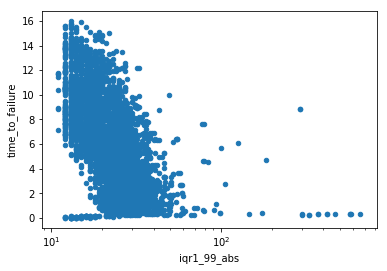

In [16]:
eng_samples.plot(x='iqr1_99_abs',y='time_to_failure',kind='scatter',logx=True)

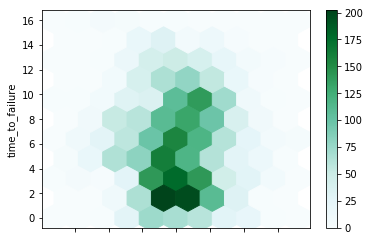

In [17]:
eng_samples.plot.hexbin(x='mean',y='time_to_failure',gridsize=10)

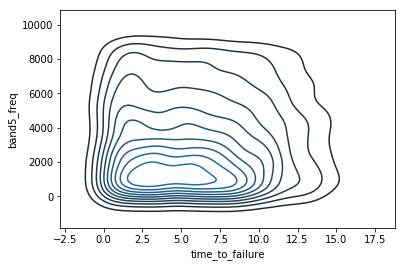

In [36]:
sns.kdeplot(eng_samples.time_to_failure,eng_samples.band5_freq)

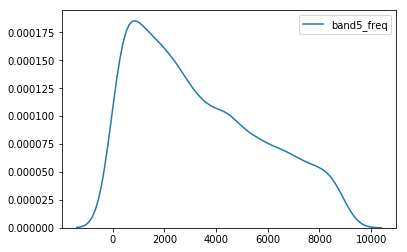

In [34]:
sns.kdeplot(eng_samples.band5_freq)

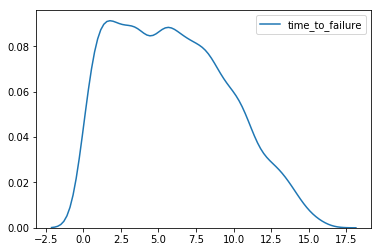

In [37]:
sns.kdeplot(eng_samples.time_to_failure)

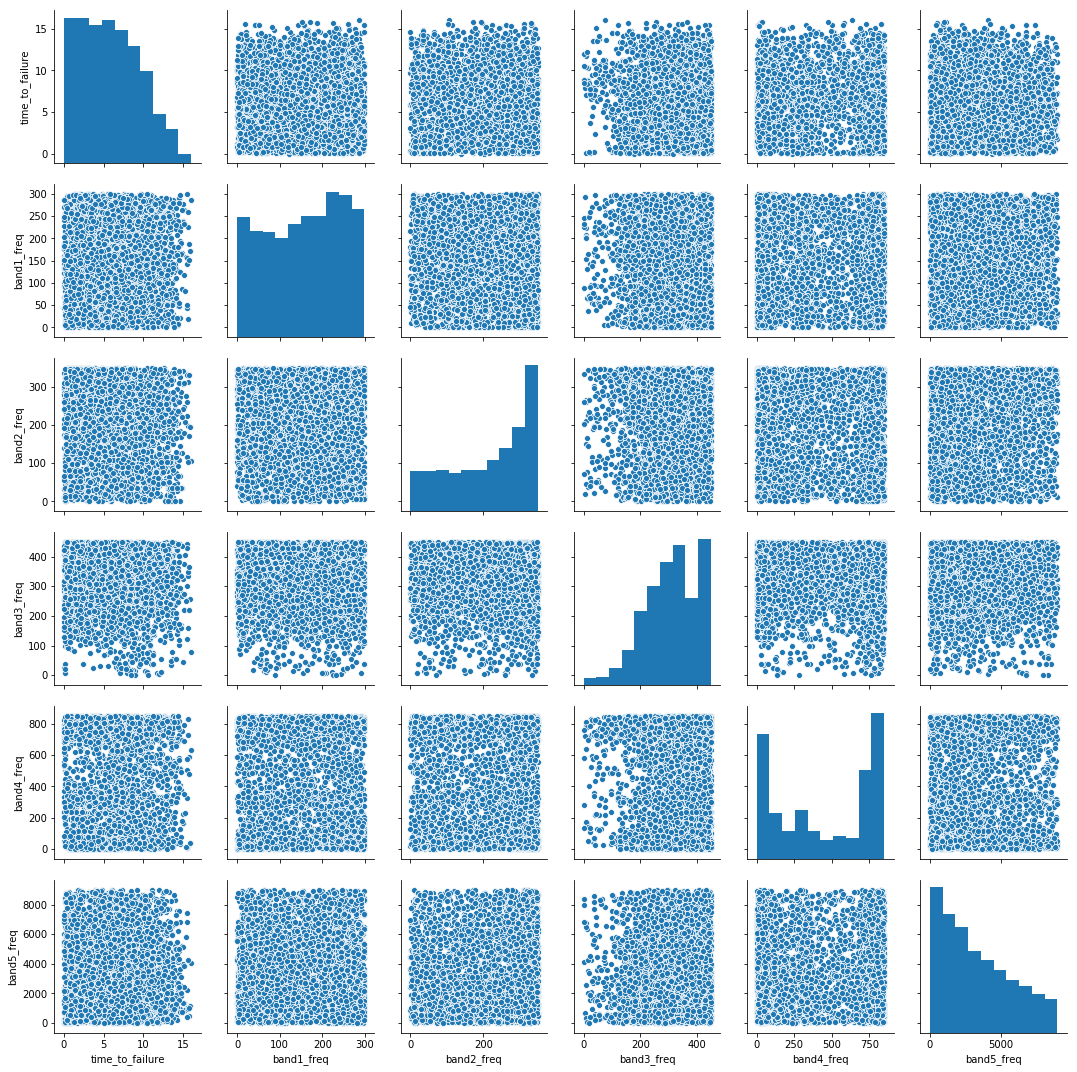

In [22]:
sns.pairplot(eng_samples[['time_to_failure','band1_freq','band2_freq','band3_freq','band4_freq','band5_freq']])

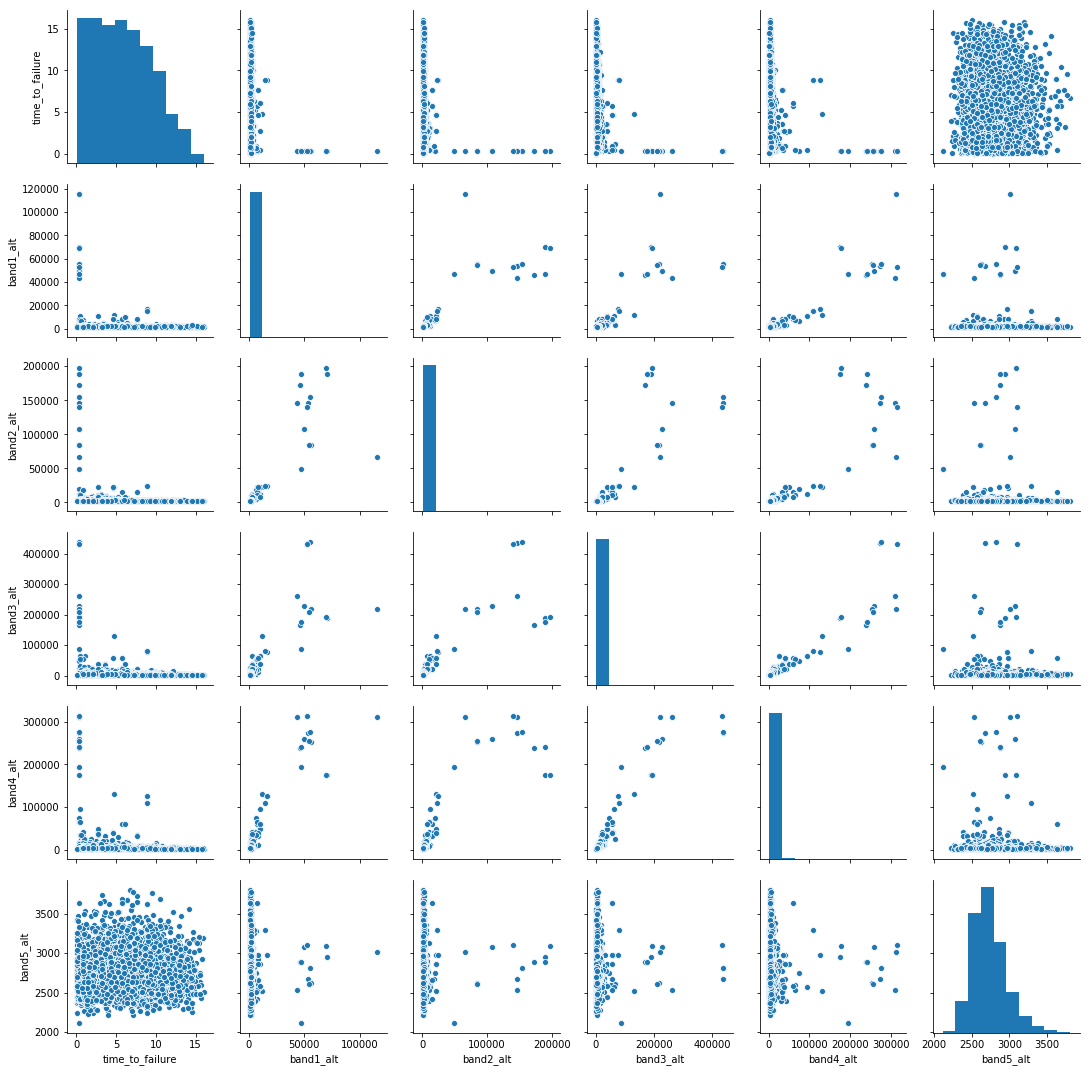

In [38]:
sns.pairplot(eng_samples[['time_to_failure','band1_alt','band2_alt','band3_alt','band4_alt','band5_alt']])

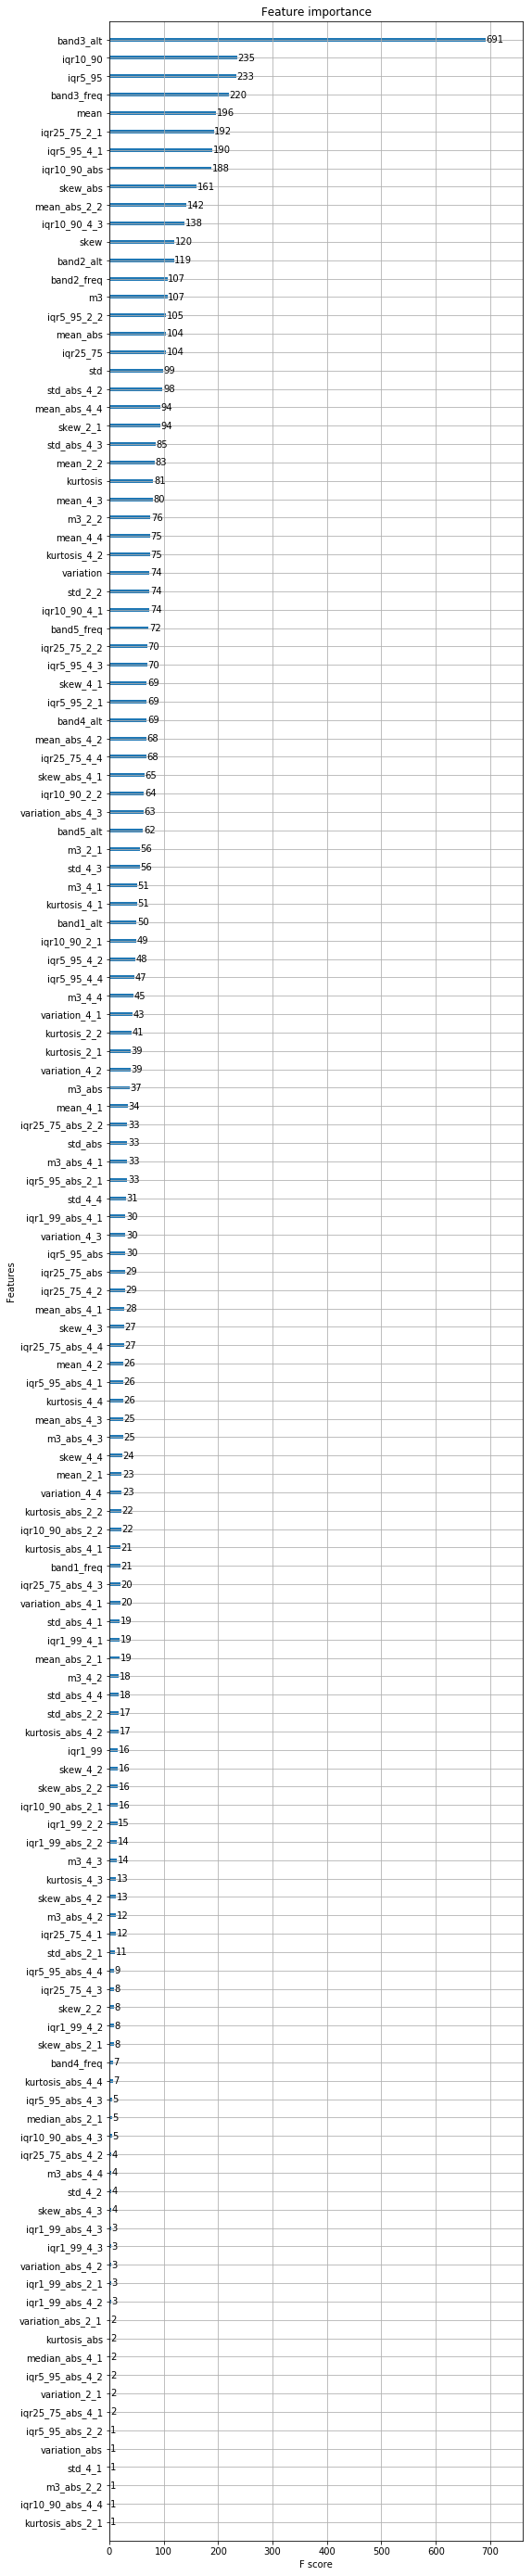

In [54]:
fig, ax = plt.subplots(figsize=(8, 50))
xgboost.plot_importance(model, ax=ax)

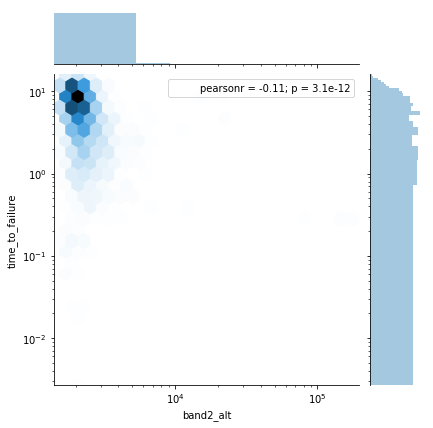

In [14]:
sns.jointplot(x='band2_alt',y='time_to_failure',data=eng_samples,kind='hex',gridsize=25,xscale='log',yscale='log').annotate(stats.pearsonr, fontsize=10)

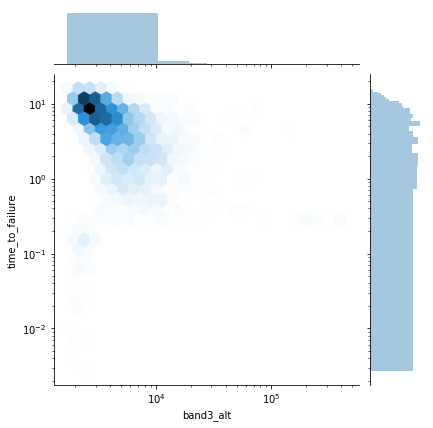

In [11]:
sns.jointplot(x='band3_alt',y='time_to_failure',data=eng_samples,kind='hex',gridsize=25,xscale='log',yscale='log')

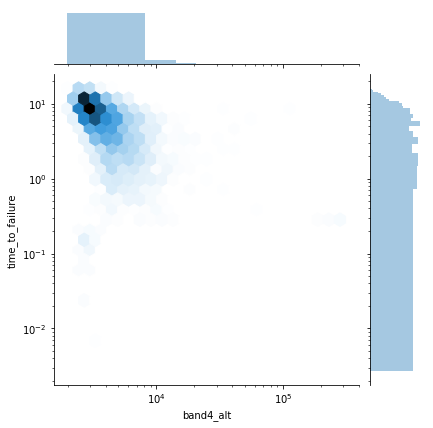

In [109]:
sns.jointplot(x='band4_alt',y='time_to_failure',data=eng_samples,kind='hex',gridsize=25,xscale='log',yscale='log')

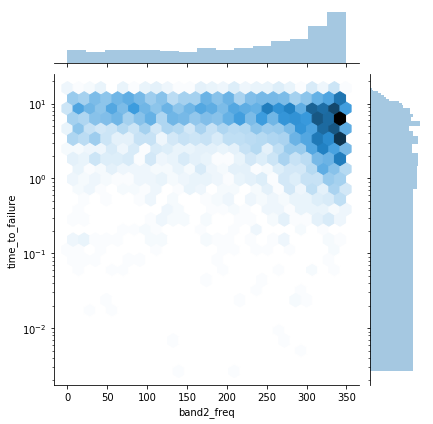

In [106]:
sns.jointplot(x='band2_freq',y='time_to_failure',data=eng_samples,kind='hex',gridsize=25,yscale='log')

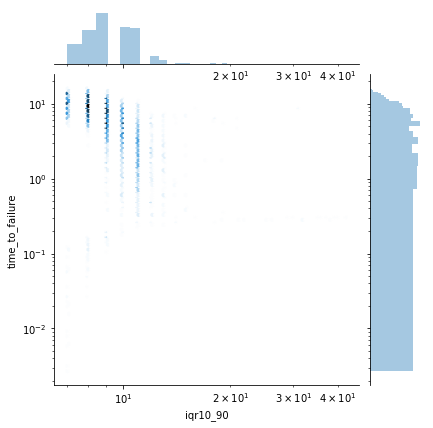

In [71]:
sns.jointplot(x='iqr10_90',y='time_to_failure',data=eng_samples,kind='hex',gridsize=100,xscale='log',yscale='log')

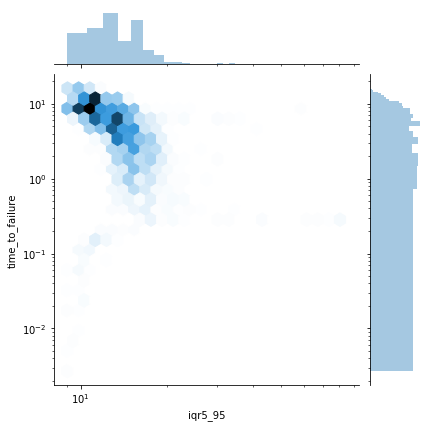

In [16]:
sns.jointplot(x='iqr5_95',y='time_to_failure',data=eng_samples,kind='hex',gridsize=25,xscale='log',yscale='log')

In [ ]:
# look into ggplot for grammar of graphics

## Drop unwanted columns from sample

In [ ]:
# insert code here


## split data into train/validation

In [ ]:
X = eng_samples.drop(labels=['time_to_failure','sequence'],axis=1)
Y = eng_samples['time_to_failure']

x_train, x_val, y_train, y_val = train_test_split(X,Y,test_size=.1,random_state=0,shuffle=False)

In [ ]:
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

## XGBoost

In [ ]:
n_estimators = 10000
learning_rate = .005
n_jobs = 8

early_stopping_rounds = 10
eval_set = [(x_val,y_val)]
verbose = True

In [ ]:
%%time

model = XGBRegressor(
    n_estimators = n_estimators, 
    learning_rate = learning_rate, 
    n_job = n_jobs
)

model.fit(x_train,y_train,
              early_stopping_rounds= early_stopping_rounds,
              eval_set = eval_set,
              eval_metric = 'mae',
              verbose = verbose
             )

from sklearn.metrics import mean_absolute_error


predictions = model.predict(x_val)
print('mae : '+str(mean_absolute_error(predictions,y_val)))

#### pickle `model`

In [41]:
# edit
MODEL_NAME = 'model_4096_all'

#leave as-is
model_filename = PROJECT_DIR/str(MODEL_NAME+'.pickle')

In [ ]:
%%time

with open(model_filename,'wb') as f:
    pickle.dump(model,f,pickle.HIGHEST_PROTOCOL)

#### delete `model` from environment

In [ ]:
del model

#### load pickled `model`

In [42]:
%%time

with open(model_filename,'rb') as f:
    model = pickle.load(f)

[22:57:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 5.75 ms, sys: 34.8 ms, total: 40.5 ms
Wall time: 106 ms


## create submission
#### start by creating a dataframe identical in format to consecutive/random samples above

In [ ]:
# edit
TEST_SAMPLES_NAME = 'test_samples'

# leave as-is
test_samples_filename = PROJECT_DIR/str(TEST_SAMPLES_NAME+'.pickle')

In [ ]:
%%time

os.chdir(PROJECT_DIR/'test')
    
test_samples = pd.DataFrame(columns=['sequence','time_to_failure']) #change to 'time_to_failure'

for i in range(len(os.listdir())):
    
    test_file = os.listdir()[i]
    
    temp_df = pd.read_csv('./'+test_file,engine='python')
        
    test_samples.loc[i,'sequence'] = np.array(temp_df['acoustic_data'].values[:])

test_samples.tail()

#### pickle `test_samples`

In [ ]:
# %%time

# with open(test_samples_filename,'wb') as f:
#     pickle.dump(test_samples,f,pickle.HIGHEST_PROTOCOL)

#### delete `test_samples` from environment

In [ ]:
del test_samples

#### load `test_samples`

In [ ]:
%%time

with open(test_samples_filename,'rb') as f:
    test_samples = pickle.load(f)

## add features

In [ ]:
%%time

generateFullFeatures(test_samples)
generateFFTFeatures(test_samples)

In [ ]:
%%time

test_samples.tail()

In [ ]:
test_samples.shape

#### pickle `test_samples_eng`

In [ ]:
%%time

with open(PROJECT_DIR/str(TEST_SAMPLES_NAME+'_eng.pickle'),'wb') as f:
    pickle.dump(test_samples,f,pickle.HIGHEST_PROTOCOL)

#### delete `test_samples_eng` from environment

In [ ]:
del test_samples

#### load `test_samples_eng`

In [ ]:
%%time

with open(PROJECT_DIR/str(TEST_SAMPLES_NAME+'_eng.pickle'),'rb') as f:
    test_samples = pickle.load(f)

In [ ]:
test_samples.tail()

In [ ]:
test_samples.shape

## make predictions/submit
This code will create a `submission.csv` file, that can be submitted to kaggle using the command line api, or website

In [ ]:
test_x = test_samples.drop(columns=['sequence','time_to_failure'])

y_pred = model.predict(test_x)

y_pred.shape

In [ ]:
submission_df = pd.DataFrame(columns=['seg_id','time_to_failure'])

submission_df['seg_id'] = pd.Series([i[:-4] for i in os.listdir(PROJECT_DIR/'test') if i[-4:]=='.csv'])
submission_df.shape

In [ ]:
submission_df['time_to_failure'] = y_pred

submission_df.to_csv(PROJECT_DIR/'submission.csv',index=False)

In [ ]:
submission_df.tail()